# Final Project

## Project Structure

This project is divided into 5 parts:
1. Background
2. Data Inspection
3. SVM
4. Logistic Regression 
5. Methods with PCA

## Background

Our goal of this project is to improve ways of pre-judging Alzheimer’s by studying brain Atlas/brain Percolation Data based on MIT's [project](https://github.com/chuktuk/Alzheimers_Disease_Analysis/tree/8a182f3e4ab2b4b88b48294186ece2fa81131cb9). The data set we used are from ADNI [website](http://adni.loni.usc.edu/data-samples/access-data/). Until now we have find three ways of imporing the existing work:
1. Using SVM
2. Using Logistic Regression
3. Applying PCA to pre-process data

## Data Inspection

### Introduction
AD is the most expensive disease in America according to the [Alzheimer’s Association](alz.org), therefore, we are trying to find ways of pre-judging Alzheimer’s by studying related dataset. This dataset was chosen because it contains information collected from the same patients over multiple exams that were conducted years apart in many cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

# import wrangle_adni to import/wrangle the data
from adnidatawrangling import wrangle_adni

# import modules from MIT work called eda, sda, ml for exploratory/statistical data analysis
import eda, sda, ml

### Row Data 

We used the data from ADNIMERGE.csv, which were processed as follows:
1. Look into dataframes using `.head()`
2. As inspired by previous work, using `.isnull().sum()` and `isnull().mean()` to describe missing values
3. For more resonable data, we filted the data, with only patients with at least two exams performed remained
4. As pointed by previous work, `final_exam` containes columns for the baseline values for each biomarker, therefore, it is treated as a more meaningful dataframe

In [2]:
# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

In [3]:
# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

In [4]:
# subset only the baseline data from the complete dataset
adni_bl, clin_bl, scan_bl = eda.get_bl_data(adni_comp, clin_data, scan_data)
final_exam.PTGENDER.value_counts()

Male      642
Female    528
Name: PTGENDER, dtype: int64

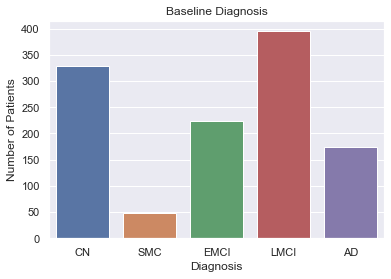

In [5]:
# plot baseline diagnosis
_ = eda.plot_bl_diag(adni_bl)

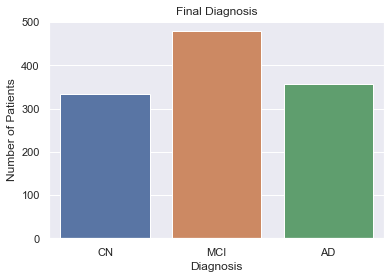

In [6]:
# plot the final diagnosis counts
_ = eda.plot_final_diag(adni_comp)

### Data Processing

To get valid training and testing data, we used the following method to processing the data:

In [7]:
from sklearn.model_selection import train_test_split

# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

# calculate the change in variables over the course of the study
eda.calc_deltas(final_exam)

# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

# examine the structure of the data
print(feature_names.shape)
print(Xd.shape, yd.shape)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

(12,)
(1134, 12) (1134,)


## SVM

We first tried to find a better SVM Model for the data, the MIT work used the following settings for SVM:

`C: 0.75, gamma: 0.08319742133210749`

And got a training accuracy: 0.8776796973518285 

and test accuracy: 0.8533724340175953

By preforming cross-valiation on different C and gamma values, our choice of SVM finally is `C=2.8, gamma=0.0073` with rbf kernel, and got an accuracy at 0.891496, which increased a little performance of the SVM model.

In [8]:
# newly constructed svm
from sklearn import svm
svc_tentative = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073, verbose=10)
svc_tentative.fit(Xd_train,yd_train)

yhat = svc_tentative.predict(Xd_test)
print('The test accuracy is: %f' % np.mean(yhat == yd_test))

[LibSVM]The test accuracy is: 0.891496


We can look into data from confusion matrix:

In [9]:
# print the confusion matrix
print(confusion_matrix(yd_test, yhat))
tn, fp, fn, tp = confusion_matrix(yd_test, yhat).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[277  10]
 [ 27  27]]
True Negatives: 277
False Positives: 10
False Negatives: 27
True Positives: 27
Detection Rate: 0.5
False Positive Rate: 0.03484320557491289


## Logistic Regression
We then tried method of Logistic Regression, for the work of MIT, they used:

In [10]:
from sklearn import linear_model
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xd_train, yd_train)

# generate predictions
y_pred = logreg.predict(Xd_test)

And got an accuracy at:

In [11]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(logreg.score(Xd_test, yd_test)))

The training accuracy was: 0.8663303909205549
The test accuracy was: 0.8651026392961877


For us, we tried the following settings and got anaccuracy at:

In [12]:
# newly constructed module
logreg = linear_model.LogisticRegression(C=1e5, solver='liblinear')
logreg.fit(Xd_train,yd_train)

yhat = logreg.predict(Xd_test)
acc = np.mean(yhat == yd_test)
print('Accuracy on the test data is %7.5f' % acc)

Accuracy on the test data is 0.89150


Also print out the confusion matrix for reference:

In [13]:
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[249  38]
 [  8  46]]
True Negatives: 249
False Positives: 38
False Negatives: 8
True Positives: 46
Detection Rate: 0.8518518518518519
False Positive Rate: 0.13240418118466898


## Applying PCA to pre-process data
We then tried to improve the accuracy by applying PCA.

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xd_train)
Xpca_train_all = pca.transform(Xd_train)
Xpca_test_all = pca.transform(Xd_test)

c:\users\38569\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


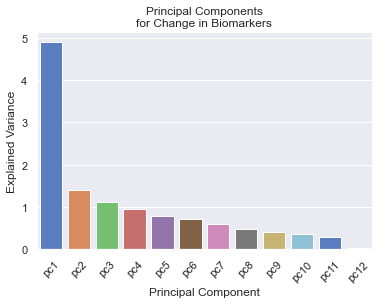

In [15]:
import seaborn as sns

labels = ['pc' + str(i+1) for i in range(feature_names.shape[0])]
ax = sns.barplot(labels, pca.explained_variance_, palette='muted')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
_ = plt.title('Principal Components\nfor Change in Biomarkers')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance')


The PCA for the change in biomarker data shows that 9 principal components can cover more than 95% of the explained variance. So we will use 9 principal components for our model.

For the work of MIT, they used:

In [16]:
pca = PCA(n_components=9)

We will now use PCA as a pre-processing step for SVM. Here we use 9 as the number of PCs. And we apply cross-validation to get the optimal C and gamma value.

In [17]:
ncomp = 9
pca = PCA(n_components=ncomp)
pca.fit(Xd_train)
Xpca_train_all = pca.transform(Xd_train)
Xpca_test_all = pca.transform(Xd_test)

C_test = np.linspace(0.1,2,20)
gam_test = np.linspace(0.001,0.1,20)

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# TODO:  Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i, C in enumerate(C_test):
    for j, gam in enumerate(gam_test):

        # Create the SVC
        svc = svm.SVC(probability=False,  kernel="rbf", C=C, gamma=gam,verbose=10)

        # Fit the data
        svc.fit(Xpca_train_all,yd_train)

        # Predict
        yhat = svc.predict(Xpca_test_all)
        acc[i,j] = np.mean(yhat == yd_test)


# Print the maximum accuracy and the corresponding best C and gamma

acc_max = np.max(acc)
ind = np.argmax(acc)
i, j = np.unravel_index(ind, (nC,ngam))

print('Max accuracy = %12.4e' % acc_max)
print('Optimal C=%12.4e gam = %12.4e' % (C_test[i], gam_test[j]))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [18]:
svc_tentative = svm.SVC(probability=False,  kernel="rbf", C=C_test[i], gamma=gam_test[j], verbose=10)
svc_tentative.fit(Xpca_train_all,yd_train)

yhat = svc_tentative.predict(Xpca_test_all)
print('The test accuracy is: %f' % np.mean(yhat == yd_test))

[LibSVM]The test accuracy is: 0.900293


Also print out the confusion matrix for reference:

In [19]:
print(confusion_matrix(yd_test, yhat))
tn, fp, fn, tp = confusion_matrix(yd_test, yhat).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[280   7]
 [ 27  27]]
True Negatives: 280
False Positives: 7
False Negatives: 27
True Positives: 27
Detection Rate: 0.5
False Positive Rate: 0.024390243902439025


It can be seen that the new SVM model we PCA behaves better in test accuracy and false positive rate.

Then we will now use PCA as a pre-processing step for logistic classification. Here we apply cross-validation to find the number of PCs.

In [20]:
from sklearn.model_selection import KFold

nfold = 5

# Create a K-fold object
kf = KFold(n_splits=nfold)
kf.get_n_splits(Xd)

# Number of PCs to try
ncomp_test = np.arange(2,12)
num_nc = len(ncomp_test)

# Accuracy:  acc[icomp,ifold]  is test accuracy when using `ncomp = ncomp_test[icomp]` in fold `ifold`.
acc = np.zeros((num_nc,nfold))

# Loop over number of components to test
for icomp, ncomp in enumerate(ncomp_test):

    # Look over the folds
    for ifold, I in enumerate(kf.split(Xd)):
        Itr, Its = I

        # Split data into training
        Xtr = Xd[Itr]
        Xts = Xd[Its]
        ytr = yd[Itr]
        yts = yd[Its]

        # Fit the PCA on the scaled training data
        pca = PCA(n_components=ncomp)
        pca.fit(Xtr)
        Ztr = pca.transform(Xtr)

        # rain a classifier on the transformed training data
        # Use a logistic regression classifier
        logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
        logreg.fit(Ztr,ytr)

        # Transform the test data through data scaler and PCA
        Zts = pca.transform(Xts)

        # Predict the labels the test data
        yhat = logreg.predict(Zts)

        # Measure the accuracy
        acc[icomp, ifold] = np.mean(yhat == yts)

Use the plt.errorbar function to plot the mean accuracy with error bars corresponding to the standard error of the accuracy as a function of the number of components. Find the optimal number of PCs to use according to the normal rule and one SE rule.

Optimal number of PCs (normal rule) = 10
Best test accuracy =  0.8607
Optimal number of PCs (one SE) = 7
Best test accuracy =  0.8457


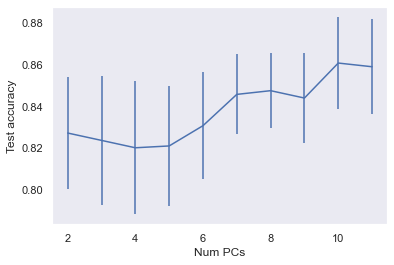

In [21]:
acc_mean = np.mean(acc, axis=1)
acc_se = np.std(acc, axis=1) / np.sqrt(nfold-1)
plt.errorbar(ncomp_test, acc_mean, yerr=acc_se)
plt.grid()
plt.xlabel('Num PCs')
plt.ylabel('Test accuracy')

# Optimal order with the normal rule
im = np.argmax(acc_mean)
print('Optimal number of PCs (normal rule) = %d' % (ncomp_test[im]))
print('Best test accuracy = %7.4f' % acc_mean[im])

# Optimal order with one SE rule
acc_tgt = acc_mean[im] - acc_se[im]
I = np.where(acc_mean >= acc_tgt)[0]
ise = I[0]
print('Optimal number of PCs (one SE) = %d' % (ncomp_test[ise]))
print('Best test accuracy = %7.4f' % acc_mean[ise])

Considering the accuracy gained by cross-validation, we can see that the best number of PCs should be 10. So we will use 10 principal components for our model.

In [22]:
ncomp = 10
pca = PCA(n_components=ncomp)
pca.fit(Xd_train)
Xpca_train_all = pca.transform(Xd_train)
Xpca_test_all = pca.transform(Xd_test)

logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
logreg.fit(Xpca_train_all,yd_train)

yhat = logreg.predict(Xpca_test_all)
acc = np.mean(yhat == yd_test)
print('Accuracy on the test data is %7.5f' % acc)

Accuracy on the test data is 0.85924


Also print out the confusion matrix for reference:

In [23]:
print(confusion_matrix(yd_test, yhat))
tn, fp, fn, tp = confusion_matrix(yd_test, yhat).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[246  41]
 [  7  47]]
True Negatives: 246
False Positives: 41
False Negatives: 7
True Positives: 47
Detection Rate: 0.8703703703703703
False Positive Rate: 0.14285714285714285


The result shows that after applying PCA, the model behaves slightly better than the orginal one with 87.0% detection rete and 14.3% false positive rate.